In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import dvu
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
import numpy as np
import seaborn as sns
import sys
import viz
sys.path.append('../notebooks_llm/')
plt.style.use('default')
dvu.set_style()
UNKS = {"Unk", "-", -1, "-1"}
df = pd.read_pickle('../data/data_clean.pkl')

mean frac_male 54.81 mean_frac_male_weighted 53.63364803882114 perc skewed 0.647 total 374


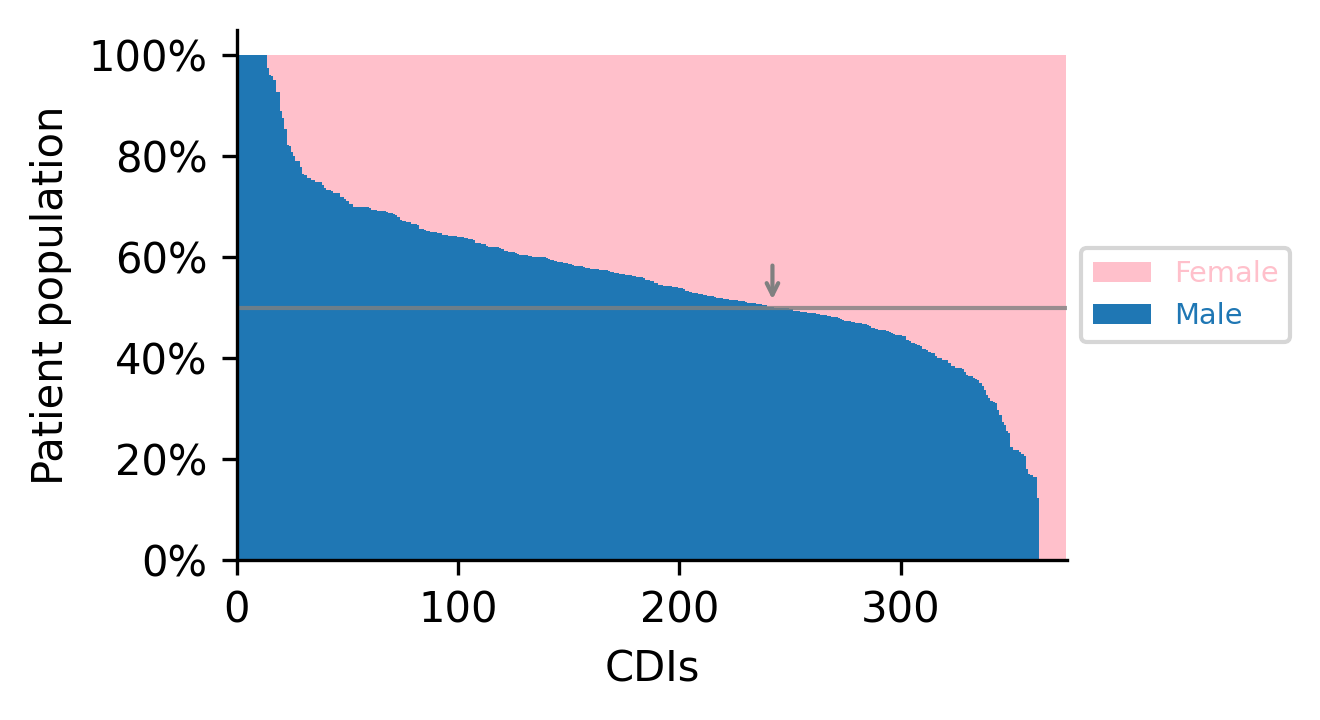

In [3]:
idxs = (df["participants___male"].notnull() & ~(df["participants___male"].isin(UNKS))) & (
    df["participants___female"].notnull() & ~(
        df["participants___female"].isin(UNKS))
)
male = df["participants___male"][idxs].astype(int)
female = df["participants___female"][idxs].astype(int)
frac_male = male / (male + female)
frac_female = female / (male + female)
ratios = (male / female).values


# make plot

args = np.argsort(frac_male)[::-1]
frac_male = frac_male.values[args] * 100
frac_female = frac_female.values[args] * 100

# barplot showing frac_male and frac_female as stacked bars
plt.figure(figsize=(4.5, 2.5), dpi=300)

num_cdis = len(frac_male)
bar_positions = np.arange(num_cdis) + 1
plt.bar(bar_positions, frac_female, width=1, bottom=frac_male,
        label="Female", color="pink")
plt.bar(bar_positions, frac_male, width=1, label="Male", color="C0")
# plt.plot([0, 242], [50, 50], color="gray", alpha=0.8, lw=1)
plt.axhline(50, color="gray", alpha=0.8, lw=1)
plt.grid(False)
plt.xlabel("CDIs")
plt.ylabel("Patient population")
# place legend to the right of the plot
plt.legend(labelcolor="linecolor", loc="center left",
           bbox_to_anchor=(1, 0.5), fontsize='x-small')
# plt.xticks(np.arange(1, num_cdis + 1, num_cdis//3), np.arange(1, num_cdis + 1, num_cdis//3))
plt.xlim(left=0, right=num_cdis + 1)
plt.yticks(np.arange(0, 101, 20), [f"{t}%" for t in np.arange(0, 101, 20)])

# annotate the point where the two bars cross 50 percent
x_cross = np.where(frac_male <= frac_female)[0][0]
plt.annotate(
    # f"{x_cross} / {num_cdis} CDIs skewed male",
    "",
    (x_cross, 50),
    xytext=(x_cross, 60),
    ha="center",
    arrowprops=dict(arrowstyle="->", color="gray"),
    fontsize="x-small",
)
print(
    "mean frac_male",
    np.mean(frac_male).round(2),
    'mean_frac_male_weighted',
    np.average(frac_male, weights=male + female),
    "perc skewed",
    round(np.sum(frac_male > frac_female) / len(frac_male), 3),
    'total', len(frac_male),
)
plt.tight_layout()
viz.savefig('sex_distr')
# Show the plot
plt.show()

### Sex-specific table

In [12]:
# df[idxs][male == 0].head(20)
d = df[idxs][(male == 0) | (female == 0)][
    [
        "title",
        "description_short",
        "paper___citation",
        "participants___male",
        "participants___female",
    ]
].sort_values(by='participants___male', ascending=False)
d.to_csv("../results/sex_specific_cdis.csv", index=False)
# with pd.option_context("display.max_colwidth", None):
# display(d.style.format(precision=0))
print('median excluding sex-specific',
      np.median(frac_male[(frac_male > 0) & (frac_male < 100)]))

median excluding sex-specific 55.26914329037149


In [6]:
(male == 0).sum(), (female == 0).sum()

(12, 13)

### Stratified table

In [ ]:
for cat in ['categorization___specialty', 'categorization___disease', 'categorization___system']:
    COUNT_THRESH = 5
    d = df[idxs]
    d["frac_male"] = df["participants___male"] / (
        df["participants___male"] + df["participants___female"]
    )
    d = d.explode(cat)[[cat, "frac_male"]]
    d = d[d[cat].notnull()]
    val_counts = d[cat].value_counts()
    d = d[d[cat].apply(lambda x: val_counts[x] >= COUNT_THRESH)]
    fracs = d.groupby(cat).mean().reset_index()
    fracs = fracs.sort_values(by="frac_male")
    cat_name = cat.split("___")[1].capitalize()
    fracs.to_csv(
        f'../results/sex_breakdown_{cat_name}.csv', index=False, float_format='%.3f')

    # plt.figure(figsize=(5, 10), dpi=200)
    # sns.barplot(y=cat, x="frac_male", data=fracs, color="mediumseagreen")
    # plt.axvline(0.5, color="gray")
    # # set yticks fontsize to small
    # plt.yticks(fontsize="xx-small")
    # plt.ylabel(cat_name)
    # plt.xlabel("Fraction of patients identified as male")
    # plt.show()

In [ ]:
# plt.figure(figsize=(4, 2), dpi=300)
# r = ratios[~np.isinf(ratios)]
# r = r[r > 0]
# logr = np.log10(r)
# print(
#     "mean",
#     r.mean().round(2),
#     'median',
#     np.median(r).round(2),
#     "frac>0",
#     (r > 1).sum(),
#     "/",
#     len(r),
#     "excluding",
#     np.sum(np.isinf(ratios)),
#     "all-male studies and",
#     np.sum(ratios == 0),
#     "all-female studies",
# )
# plt.hist(logr[logr < 0], color="pink")  # , bins=100)
# plt.hist(logr[logr >= 0], color="C0")  # , bins=100)
# plt.axvline(0, color="black", ls="--")
# ticks = plt.xticks()[0]
# plt.xticks(ticks, [f"$10^{{{t}}}$" for t in ticks])
# plt.xlabel("Ratio (male / female)")
# plt.ylabel("Count")
# plt.show()

In [ ]:
# # VIOLIN PLOT ##

# frac_male = frac_male = df['frac_male'][idxs & (df['num_male_corrected'] >= 1) & (df['num_female_corrected'] >= 1)]
# frac_female = 1 - frac_male

# dd = pd.DataFrame.from_dict(
#     {
#         "frac": frac_male.tolist() + frac_female.tolist(),
#         "sex": [0] * len(frac_male) + [1] * len(frac_female),
#     }
# )
# sns.violinplot(dd, x="sex", y="frac", palette=["C0", "pink"], cut=0, bw=0.3)